In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
import numpy as np
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv("ca96.csv.gz",compression='gzip')
df.authorship.value_counts().head(30)

PER CURIAM          2201
NEWMAN              1025
RADER                975
LOURIE               921
MICHEL               679
BRYSON               656
DYK                  641
SCHALL               607
MAYER                571
CLEVENGER            569
PROST                531
ARCHER               472
PLAGER               418
GAJARSA              409
FRIEDMAN             392
RICH                 391
NIES                 357
LINN                 356
MOORE                310
MARKEY               237
O'MALLEY             232
REYNA                197
WALLACH              171
SMITH                167
DAVIS                163
BISSELL              151
TARANTO              146
MARIS                126
Alvin A.  Schall     121
NICHOLS              121
Name: authorship, dtype: int64

In [3]:
df.authorship = df.authorship.str.upper()
names = []
for i in df.authorship.value_counts().head(100).index:
    if i != 'PER CURIAM' and i != 'PER CURIAM:':
        names.append(i)
copy = pd.DataFrame()
temp = df[df.word_count > 50]
for name in names:
    copy = copy.append(temp[temp.authorship == name])
copy.date_standard = copy.date_standard.str[:4]
copy.date_standard = copy.date_standard.astype(int)
copy = copy.drop(columns=['opinion_type','opinion_id','word_count','authors','dc_source','judges_refined'])
copy

,dc_identifier,opinion,authorship,date_standard
71,4HVG-5MN0-003B-933P-00000-00,"NEWMAN, Circuit Judge.\n\nZhejiang Native Prod...",NEWMAN,2005
125,45DD-M3R0-003B-9408-00000-00,"NEWMAN, Circuit Judge, dissenting.\n\nI respec...",NEWMAN,2002
207,7W37-8S10-Y9NK-S026-00000-00,"ON MOTION\n\nNEWMAN, Circuit Judge.\n\nORDER\n...",NEWMAN,2009
283,4B58-D840-003B-923N-00000-00,"NEWMAN, Circuit Judge, dissenting.\n\nRespectf...",NEWMAN,2003
412,5BYD-K3D1-F04B-M008-00000-00,"Newman, Circuit Judge, dissenting.\n\nHoffmann...",NEWMAN,2014
...,...,...,...,...
16679,3S4X-2RW0-003B-04DK-00000-00,The complainant was the owner of the Le Grand ...,MARIS,1948
16972,3S4W-XCV0-003B-02DN-00000-00,The complainants in this case ask this court t...,MARIS,1955
17030,3S4X-0K20-003B-00KP-00000-00,The complainant seeks the review of the denial...,MARIS,1952
17460,3S4X-0SY0-003B-01F2-00000-00,"Before MARIS, Chief Judge, and MAGRUDER and Mc...",MARIS,1951


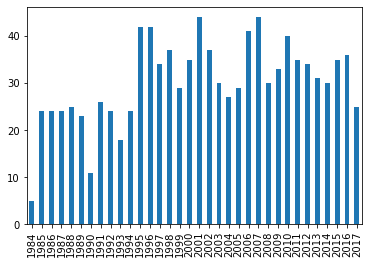

In [4]:
copy[copy.authorship == names[0]].date_standard.value_counts().sort_index().plot(kind='bar')

In [5]:
copy.opinion = copy.opinion.str.replace('Senior Circuit Judge','')
copy.opinion = copy.opinion.str.replace('Senior Circuit Judge'.upper(),'')
copy.opinion = copy.opinion.str.replace('Senior District Judge','')
copy.opinion = copy.opinion.str.replace('Senior District Judge'.upper(),'')
copy.opinion = copy.opinion.str.replace('Circuit Judges','')
copy.opinion = copy.opinion.str.replace('CIRCUIT JUDGES','')
copy.opinion = copy.opinion.str.replace('District Judges','')
copy.opinion = copy.opinion.str.replace('District Judges'.upper(),'')
copy.opinion = copy.opinion.str.replace('District Judge','')
copy.opinion = copy.opinion.str.replace('District Judge'.upper(),'')
copy.opinion = copy.opinion.str.replace('Circuit Judge','')
copy.opinion = copy.opinion.str.replace('CIRCUIT JUDGE','')
copy.opinion = copy.opinion.str.replace('Circuit Justice','')
copy.opinion = copy.opinion.str.replace('Circuit Justice'.upper(),'')
copy.opinion = copy.opinion.str.replace('D\.J\.','')
copy.opinion = copy.opinion.str.replace('D\. J\.','')
copy.opinion = copy.opinion.str.replace('C\.J\.','')
copy.opinion = copy.opinion.str.replace('C\. J\.','')
copy.opinion = copy.opinion.str.replace('Senior Judge','')
copy.opinion = copy.opinion.str.replace('Senior Judge'.upper(),'')
copy.opinion = copy.opinion.str.replace('Associate Justice','')
copy.opinion = copy.opinion.str.replace('Associate Justice'.upper(),'')
copy.opinion = copy.opinion.str.replace('Chief Judge','')
copy.opinion = copy.opinion.str.replace('Chief Judge'.upper(),'')
copy.opinion = copy.opinion.str.replace('Judge','')
copy.opinion = copy.opinion.str.replace('Judge'.upper(),'')
copy.opinion = copy.opinion.str.replace('HONORABLE','')

for name in names:
    copy.opinion = copy.opinion.str.replace(name.upper(),'')
    copy.opinion = copy.opinion.str.replace(name,'')
    copy.opinion = copy.opinion.str.replace(name[:1].upper()+name[1:].lower(),'')





copy.opinion = copy.opinion.str.replace('O\'Malley',' ')
copy.opinion = copy.opinion.str.replace('O\'Malley'.upper(),' ')
copy.opinion = copy.opinion.str.replace('\n',' ')

In [6]:
copy.opinion = copy.opinion.str.replace('\\\'','')
copy.opinion = copy.opinion.str.replace('(','')
copy.opinion = copy.opinion.str.replace(')','')
copy.opinion = copy.opinion.apply(lambda x: re.sub(r"\s\w\.", "", x))
copy.opinion = copy.opinion.apply(lambda x: re.sub(r"\s\.\s", " ", x))
copy.opinion = copy.opinion.apply(lambda x: re.sub(r"\s\.\s", " ", x))
copy.opinion = copy.opinion.apply(lambda x: re.sub(r"\s\,", ",", x))
copy.opinion = copy.opinion.apply(lambda x: re.sub(r"\d+", "", x))
copy.opinion = copy.opinion.apply(lambda x: re.sub(r"-", "", x))
copy.opinion = copy.opinion.str.replace('S\.C\.','')
copy.opinion = copy.opinion.str.replace('Ct\.','Ct')
copy.opinion = copy.opinion.str.replace('Ed\.','Ed')
copy.opinion = copy.opinion.str.replace('Dec\.','Dec')
copy.opinion = copy.opinion.str.replace(' No\.',' No')
copy.opinion = copy.opinion.str.replace(' pt\.',' pt')
copy.opinion = copy.opinion.str.replace(' Rep\.',' Rep')
copy.opinion = copy.opinion.str.replace(' Tr\.',' Tr')
copy.opinion = copy.opinion.str.replace(' Arg\.',' Arg')
copy.opinion = copy.opinion.str.replace(' Nev\.',' Nev')
copy.opinion = copy.opinion.str.replace(' Rev\.',' Rev')
copy.opinion = copy.opinion.str.replace(' Stat\.',' Stat')
copy.opinion = copy.opinion.str.replace(' Cent\.',' Cent')
copy.opinion = copy.opinion.str.replace(' Ore\.',' Ore')
copy.opinion = copy.opinion.str.replace(' Co\.',' Co')
copy.opinion = copy.opinion.str.replace(' Ins\.',' Ins')
copy.opinion = copy.opinion.str.replace('S\.','')
copy.opinion = copy.opinion.str.replace('Cf\.','Cf')
copy.opinion = copy.opinion.str.replace('Id\.','Id')
copy.opinion = copy.opinion.str.replace(' ,',',')
copy.opinion = copy.opinion.str.replace(' \.','.')
copy.opinion = copy.opinion.str.replace('§','')
copy.opinion = copy.opinion.str.replace('$','')
copy.opinion = copy.opinion.str.replace('\.\.','.')
copy.opinion = copy.opinion.str.replace('\.\.','.')
copy.opinion = copy.opinion.str.replace(',,',',')
copy.opinion = copy.opinion.str.replace(',,',',')
copy.opinion = copy.opinion.str.replace(',\.',',')
copy.opinion = copy.opinion.str.replace('"',' ')
copy.opinion = copy.opinion.str.replace('II','')
copy.opinion = copy.opinion.str.replace('III','')
copy.opinion = copy.opinion.str.replace('  ',' ')

In [7]:
# Prints the first 200 characters of the first 10 cleaned opinion texts of a given judge.
judge = 0
print(names[judge]+'\n')
for x in range(10):
    print(copy.opinion[copy.loc[copy.authorship==names[judge]].index[x]][:200]+'\n\n')

NEWMAN

, Zhejiang Native Produce & Animal ByProducts Import & Export Corporation and other importers and exporters collectively Zhejiang appeal the decision of the United States Court of International Trade,


, dissenting. I respectfully dissent, for the majoritys decision negates the statutory method of protecting endangered sea turtles. The Court of International Trade applied the statute in accordance w


ON MOTION, ORDER The United States moves to dismiss Lisk Wyckoff, Jr.s appeal as premature. Wyckoff does not oppose. Wyckoff filed a complaint in the United States Court of Federal Claims seeking a re


, dissenting. Respectfully, I dissent. This case is not distinguishable from the definitive decision of United States Winstar Corp., , Ed d, Ct , wherein the government agreed to a specified accountin


, dissenting. HoffmannLaRoches onceamonth Boniva® ibandronate medication for osteoporosis required twelve years of research and clinical testing and evaluation to demonstrate its e

In [8]:
#get rough estimate for total number of top 10 authors in all 3 splits
top = 2000
bot = 1970
split1 = pd.DataFrame()
for x in copy[copy.date_standard<=bot].authorship.value_counts().head(10).index:
    temp = copy[copy.authorship == x]
    split1 = split1.append(temp[temp.date_standard<=bot])
split2 = pd.DataFrame()
for x in copy[copy.date_standard<top][copy.date_standard>bot].authorship.value_counts().head(10).index:
    temp = copy[copy.authorship == x]
    split2 = split2.append(temp[temp.date_standard<top][temp.date_standard>bot])
split3 = pd.DataFrame()
for x in copy[copy.date_standard>=top].authorship.value_counts().head(10).index:
    temp = copy[copy.authorship == x]
    split3 = split3.append(temp[temp.date_standard>=top])

for i in range(3):
    totalNum = split1.shape[0]+split2.shape[0]+split3.shape[0]
    print('totalNum = '+str(totalNum))
    print(split1.shape)
    print(split2.shape)
    print(split3.shape)    

    #initialize the splits so we can iterate over them
    top = 2020
    bot = 1800
    split1 = pd.DataFrame()
    for x in copy[copy.date_standard<=bot].authorship.value_counts().head(10).index:
        temp = copy[copy.authorship == x]
        split1 = split1.append(temp[temp.date_standard<=bot])
    split2 = pd.DataFrame()
    for x in copy[copy.date_standard<top][copy.date_standard>bot].authorship.value_counts().head(10).index:
        temp = copy[copy.authorship == x]
        split2 = split2.append(temp[temp.date_standard<top][temp.date_standard>bot])
    split3 = pd.DataFrame()
    for x in copy[copy.date_standard>=top].authorship.value_counts().head(10).index:
        temp = copy[copy.authorship == x]
        split3 = split3.append(temp[temp.date_standard>=top])
    
    
    
    
    #loop to iterate 
    while split1.shape[0] < totalNum/3:
        bot += 1
        split1 = pd.DataFrame()
        for x in copy[copy.date_standard<=bot].authorship.value_counts().head(10).index:
            temp = copy[copy.authorship == x]
            split1 = split1.append(temp[temp.date_standard<=bot])    
    while split3.shape[0] < totalNum/3:
        top -= 1
        split3 = pd.DataFrame()
        for x in copy[copy.date_standard>=top].authorship.value_counts().head(10).index:
            temp = copy[copy.authorship == x]
            split3 = split3.append(temp[temp.date_standard>=top])
    split2 = pd.DataFrame()
    for x in copy[copy.date_standard<top][copy.date_standard>bot].authorship.value_counts().head(10).index:
        temp = copy[copy.authorship == x]
        split2 = split2.append(temp[temp.date_standard<top][temp.date_standard>bot])
    

    print(split1.shape)
    print(split2.shape)
    print(split3.shape)
    print('top = '+str(top)+' bot = '+str(bot))

totalNum = 8608
(126, 4)
(3531, 4)
(4951, 4)


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(3024, 4)
(2878, 4)
(3031, 4)
top = 2007 bot = 1997
totalNum = 8933
(3024, 4)
(2878, 4)
(3031, 4)
(3024, 4)
(2878, 4)
(3031, 4)
top = 2007 bot = 1997
totalNum = 8933
(3024, 4)
(2878, 4)
(3031, 4)
(3024, 4)
(2878, 4)
(3031, 4)
top = 2007 bot = 1997


# Bag of Words approach

## Split 1

In [9]:
split1.authorship.value_counts()

ARCHER      391
NIES        356
NEWMAN      346
RICH        339
RADER       312
MICHEL      286
LOURIE      266
MAYER       253
FRIEDMAN    242
MARKEY      233
Name: authorship, dtype: int64

In [10]:
print('Number of Datapoints: ', split1.shape[0])

Number of Datapoints:  3024


In [11]:
split1names = split1.authorship.unique()

for index, name in enumerate(split1names):
    split1.authorship = split1.authorship.str.replace(name, str(index))
split1.authorship = split1.authorship.astype(int)

In [12]:
vectorizer1 = CountVectorizer(lowercase=False, ngram_range=(1,3), min_df=30, max_features=3000)
bowM1 = vectorizer1.fit_transform(split1.opinion)
#print(bowM1.toarray().shape)
#print(vectorizer1.get_feature_names())

In [13]:
X1 = pd.DataFrame.sparse.from_spmatrix(bowM1)
X1 = X1.sparse.to_dense()

In [14]:
for x in range(0,len(X1.columns)):
    mean = X1.iloc[:,x].mean()
    std = X1.iloc[:,x].std()
    X1.iloc[:,x] = (X1.iloc[:,x] - mean)/std

In [15]:
Y1 = split1.authorship.to_frame().reset_index().drop(columns=['index'])

X1_Training, X1_Testing, y1_Training, y1_Testing = train_test_split(X1, Y1, test_size=0.2, random_state=1234)

In [16]:
scores = [0,0,0,0,0]

for i in range(0,5):
    classifier = svm.SVC(kernel='poly',degree=1,C=1,class_weight='balanced', verbose=True, probability=True)

    X1_train, X1_test, y1_train, y1_test = train_test_split(X1_Training, y1_Training, test_size=0.2, random_state=i)
    classifier.fit(np.array(X1_train), np.array(y1_train))
    values = classifier.predict_proba(np.array(X1_test))
    
    correct = 0
    counter = 0
    for k in range(0,y1_test.size):
        if np.amax(values[k]) == values[k][int(y1_test.iloc[k])]:
            correct += 1
        counter += 1
        
    scores[i] = correct/counter
    print(scores[i])
    
print('Accuracy: ', np.array(scores).mean(), ' +/- ', np.array(scores).std())

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.7169421487603306
[LibSVM]

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6673553719008265
[LibSVM]

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.7128099173553719
[LibSVM]

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6797520661157025
[LibSVM]

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.71900826446281
Accuracy:  0.6991735537190082  +/-  0.021376061415500094


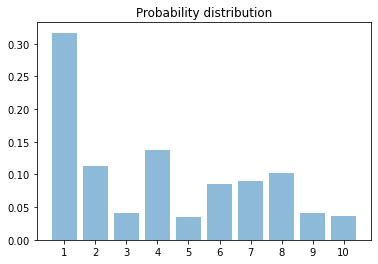

Accuracy:  0.6958677685950413


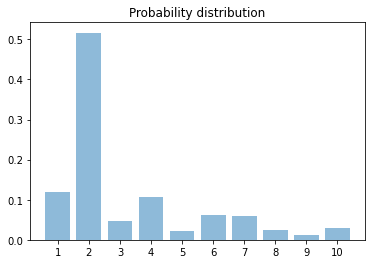

Accuracy:  0.6958677685950413


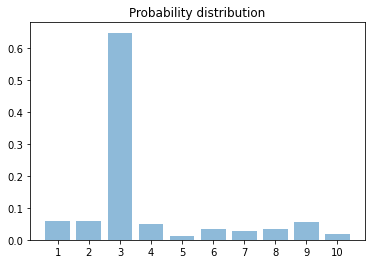

Accuracy:  0.6958677685950413


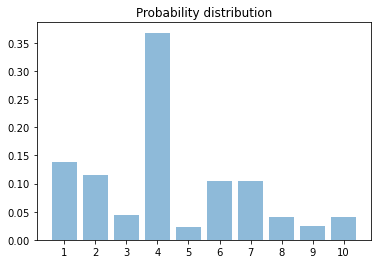

Accuracy:  0.6958677685950413


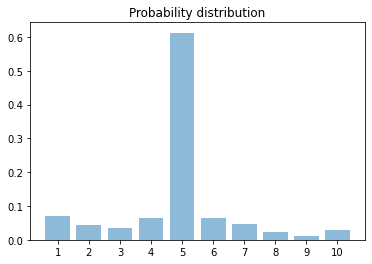

Accuracy:  0.6958677685950413


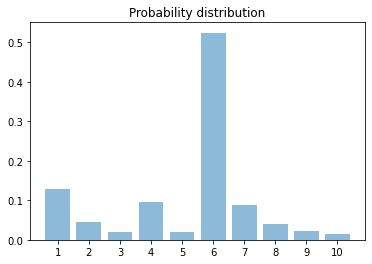

Accuracy:  0.6958677685950413


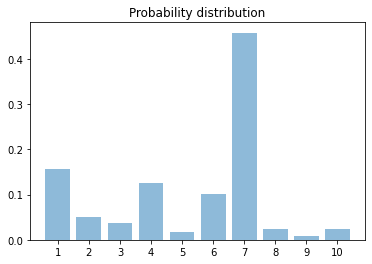

Accuracy:  0.6958677685950413


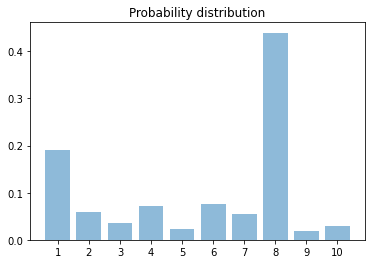

Accuracy:  0.6958677685950413


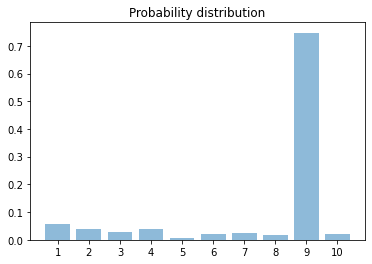

Accuracy:  0.6958677685950413


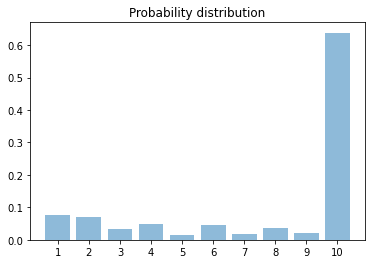

Accuracy:  0.6958677685950413


In [17]:
values1 = classifier.predict_proba(np.array(X1_Testing))
data1 = pd.DataFrame(data=values1)
data1['Y'] = y1_Testing.authorship.to_frame().reset_index().drop(columns=['index'])
data1.to_csv('96_split1_results.csv', index=False)

for l in range(0,10):
    probs = [0,0,0,0,0,0,0,0,0,0]
    count = 0

    for i,row in data1.iterrows():
        if(row['Y'] == l):
            for k in range(0,10):
                probs[k] += row[k]
            count += 1
    
    for k in range(0,10):
        probs[k] = probs[k]/count

    objects = ('1','2','3','4','5','6','7','8','9','10')
    y_pos = np.arange(len(objects))
    performance = probs

    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.title('Probability distribution')

    plt.show()
    
    correct = 0
    counter = 0
    for k in range(0,y1_Testing.size):
        if np.amax(values1[k]) == values1[k][int(y1_Testing.iloc[k])]:
            correct += 1
        counter += 1
        
    print('Accuracy: ',correct/counter)

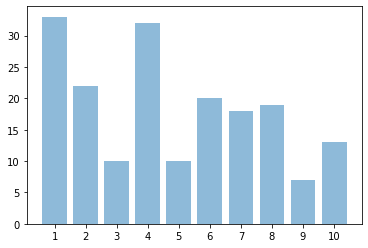

[33, 22, 10, 32, 10, 20, 18, 19, 7, 13]


In [18]:
wrongPredictions = [0,0,0,0,0,0,0,0,0,0]

for i,row in data1.iterrows():
    if row[int(row['Y'])] != np.amax(row[:10]):
        wrongPredictions[(int(row['Y']))] += 1
        #print(i)
        
objects = ('1','2','3','4','5','6','7','8','9','10')
y_pos = np.arange(len(objects))
performance = wrongPredictions

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.show()

print(wrongPredictions)

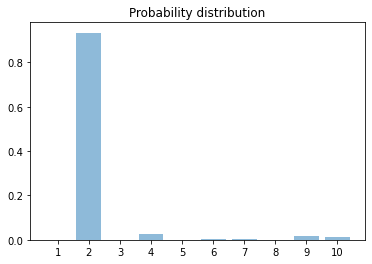

In [19]:
objects = ('1','2','3','4','5','6','7','8','9','10')
y_pos = np.arange(len(objects))
performance = values1[233]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title('Probability distribution')

plt.show()

## Split 2

In [20]:
split2.authorship.value_counts()

RADER        391
MICHEL       310
NEWMAN       309
SCHALL       298
LOURIE       284
BRYSON       277
CLEVENGER    269
GAJARSA      265
DYK          255
LINN         220
Name: authorship, dtype: int64

In [21]:
print('Number of Datapoints: ', split2.shape[0])

Number of Datapoints:  2878


In [22]:
split2names = split2.authorship.unique()

for index, name in enumerate(split2names):
    split2.authorship = split2.authorship.str.replace(name, str(index))
split2.authorship = split2.authorship.astype(int)

In [23]:
vectorizer2 = CountVectorizer(lowercase=False, ngram_range=(1,3), min_df=30, max_features=3000)
bowM2 = vectorizer2.fit_transform(split2.opinion)
#print(bowM2.toarray().shape)
#print(vectorizer2.get_feature_names())

In [24]:
X2 = pd.DataFrame.sparse.from_spmatrix(bowM2)
X2 = X2.sparse.to_dense()

In [25]:
for x in range(0,len(X2.columns)):
    mean = X2.iloc[:,x].mean()
    std = X2.iloc[:,x].std()
    X2.iloc[:,x] = (X2.iloc[:,x] - mean)/std

In [26]:
Y2 = split2.authorship.to_frame().reset_index().drop(columns=['index'])

X2_Training, X2_Testing, y2_Training, y2_Testing = train_test_split(X2, Y2, test_size=0.2, random_state=1234)

In [27]:
scores = [0,0,0,0,0]

for i in range(0,5):
    classifier = svm.SVC(kernel='poly',degree=1,C=1,class_weight='balanced', verbose=True, probability=True)

    X2_train, X2_test, y2_train, y2_test = train_test_split(X2_Training, y2_Training, test_size=0.2, random_state=i)
    classifier.fit(np.array(X2_train), np.array(y2_train))
    values = classifier.predict_proba(np.array(X2_test))
    
    correct = 0
    counter = 0
    for k in range(0,y2_test.size):
        if np.amax(values[k]) == values[k][int(y2_test.iloc[k])]:
            correct += 1
        counter += 1
        
    scores[i] = correct/counter
    print(scores[i])
    
print('Accuracy: ', np.array(scores).mean(), ' +/- ', np.array(scores).std())

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.7418655097613883
[LibSVM]

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.8047722342733189
[LibSVM]

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.7245119305856833
[LibSVM]

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.7288503253796096
[LibSVM]

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.735357917570499
Accuracy:  0.7470715835140999  +/-  0.02944360867845059


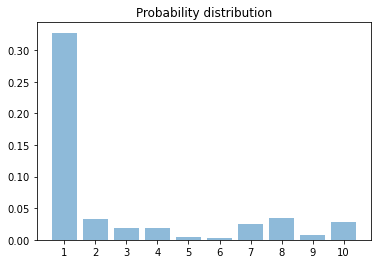

Accuracy:  0.7152777777777778


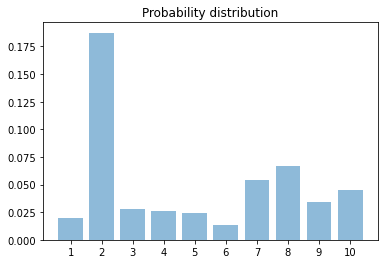

Accuracy:  0.7152777777777778


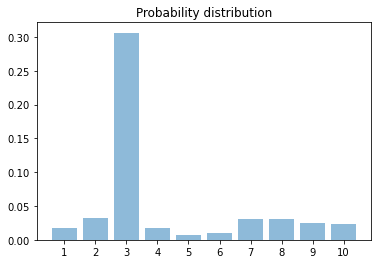

Accuracy:  0.7152777777777778


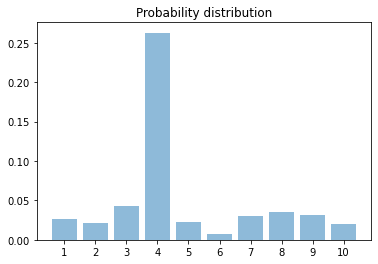

Accuracy:  0.7152777777777778


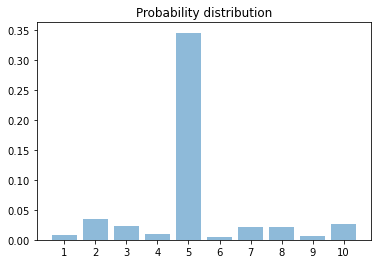

Accuracy:  0.7152777777777778


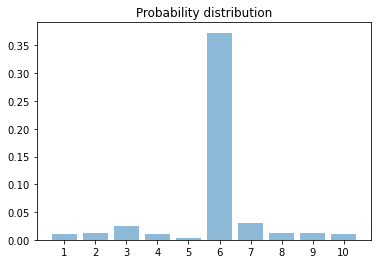

Accuracy:  0.7152777777777778


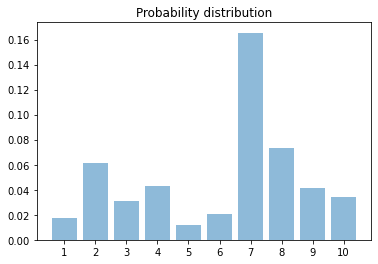

Accuracy:  0.7152777777777778


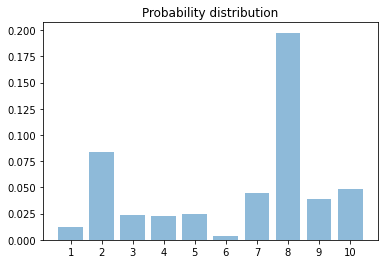

Accuracy:  0.7152777777777778


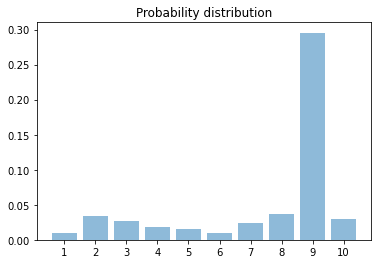

Accuracy:  0.7152777777777778


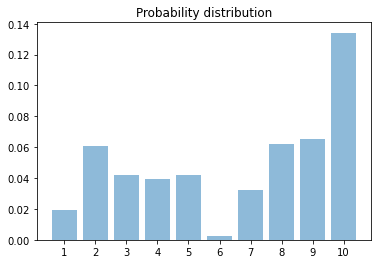

Accuracy:  0.7152777777777778


In [28]:
values2 = classifier.predict_proba(np.array(X2_Testing))
data2 = pd.DataFrame(data=values2)
data2['Y'] = y2_Testing.authorship.to_frame().reset_index().drop(columns=['index'])
data2.to_csv('96_split2_results.csv', index=False)

for l in range(0,10):
    probs = [0,0,0,0,0,0,0,0,0,0]
    count = 0

    for i,row in data2.iterrows():
        if(row['Y'] == l):
            count += 1
            for k in range(0,10):
                probs[k] += row[k]
            count += 1

    for k in range(0,10):
        probs[k] = probs[k]/count

    objects = ('1','2','3','4','5','6','7','8','9','10')
    y_pos = np.arange(len(objects))
    performance = probs

    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.title('Probability distribution')

    plt.show()
    
    correct = 0
    counter = 0
    for k in range(0,y2_Testing.size):
        if np.amax(values2[k]) == values2[k][int(y2_Testing.iloc[k])]:
            correct += 1
        counter += 1
        
    print('Accuracy: ',correct/counter)

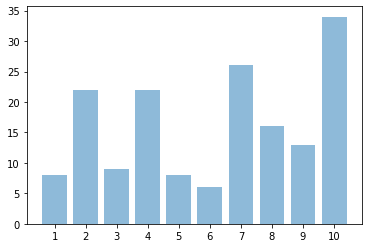

[8, 22, 9, 22, 8, 6, 26, 16, 13, 34]


In [29]:
wrongPredictions = [0,0,0,0,0,0,0,0,0,0]

for i,row in data2.iterrows():
    if row[int(row['Y'])] != np.amax(row[:10]):
        wrongPredictions[(int(row['Y']))] += 1
        #print(i)
        
objects = ('1','2','3','4','5','6','7','8','9','10')
y_pos = np.arange(len(objects))
performance = wrongPredictions

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.show()

print(wrongPredictions)

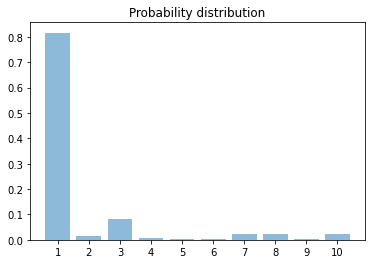

In [30]:
objects = ('1','2','3','4','5','6','7','8','9','10')
y_pos = np.arange(len(objects))
performance = values2[233]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title('Probability distribution')

plt.show()

## Split 3

In [31]:
split3.authorship.value_counts()

PROST       390
DYK         387
NEWMAN      373
LOURIE      370
MOORE       315
RADER       270
BRYSON      269
O'MALLEY    235
LINN        221
REYNA       201
Name: authorship, dtype: int64

In [32]:
print('Number of Datapoints: ', split3.shape[0])

Number of Datapoints:  3031


In [33]:
split3names = split3.authorship.unique()

for index, name in enumerate(split3names):
    split3.authorship = split3.authorship.str.replace(name, str(index))
split3.authorship = split3.authorship.astype(int)

In [34]:
vectorizer3 = CountVectorizer(lowercase=False, ngram_range=(1,3), min_df=30, max_features=3000)
bowM3 = vectorizer3.fit_transform(split3.opinion)
#print(bowM3.toarray().shape)
#print(vectorizer3.get_feature_names())

In [35]:
X3 = pd.DataFrame.sparse.from_spmatrix(bowM3)
X3 = X3.sparse.to_dense()

In [36]:
for x in range(0,len(X3.columns)):
    mean = X3.iloc[:,x].mean()
    std = X3.iloc[:,x].std()
    X3.iloc[:,x] = (X3.iloc[:,x] - mean)/std

In [37]:
Y3 = split3.authorship.to_frame().reset_index().drop(columns=['index'])

X3_Training, X3_Testing, y3_Training, y3_Testing = train_test_split(X3, Y3, test_size=0.2, random_state=1234)

In [38]:
scores = [0,0,0,0,0]

for i in range(0,5):
    classifier = svm.SVC(kernel='poly',degree=1,C=1,class_weight='balanced', verbose=True, probability=True)

    X3_train, X3_test, y3_train, y3_test = train_test_split(X3_Training, y3_Training, test_size=0.2, random_state=i)
    classifier.fit(np.array(X3_train), np.array(y3_train))
    values = classifier.predict_proba(np.array(X3_test))
    
    correct = 0
    counter = 0
    for k in range(0,y3_test.size):
        if np.amax(values[k]) == values[k][int(y3_test.iloc[k])]:
            correct += 1
        counter += 1
        
    scores[i] = correct/counter
    print(scores[i])
    
print('Accuracy: ', np.array(scores).mean(), ' +/- ', np.array(scores).std())

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[LibSVM]0.5938144329896907
[LibSVM]

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6123711340206186
[LibSVM]

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6103092783505155
[LibSVM]

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.5938144329896907
[LibSVM]

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6391752577319587
Accuracy:  0.6098969072164949  +/-  0.016618096230606075


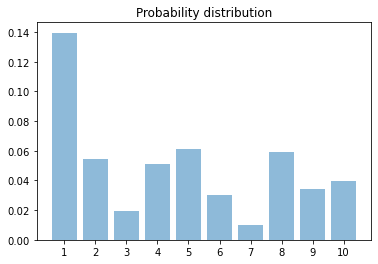

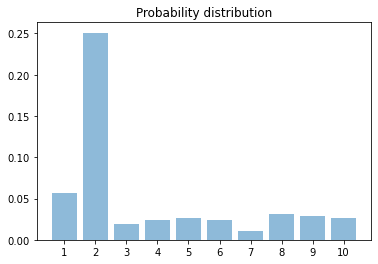

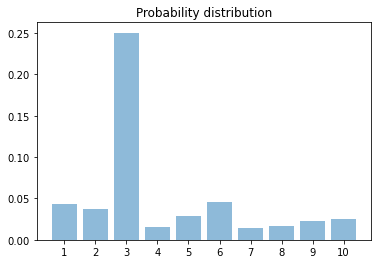

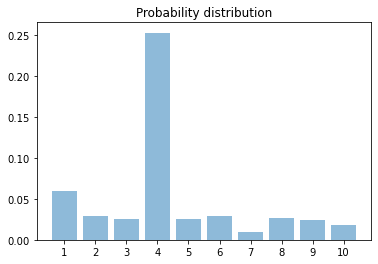

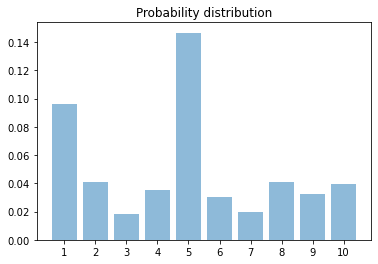

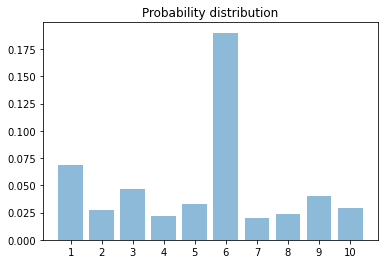

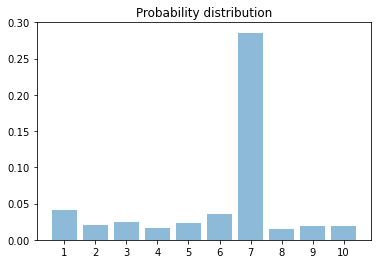

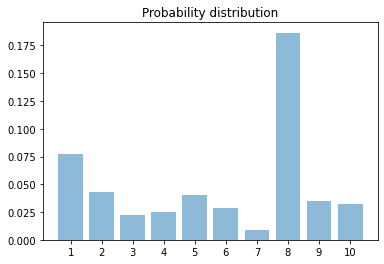

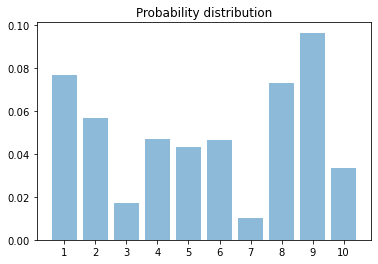

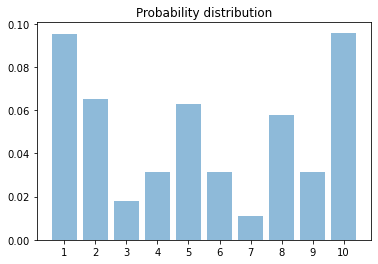

In [39]:
values3 = classifier.predict_proba(np.array(X3_Testing))
data3 = pd.DataFrame(data=values3)
data3['Y'] = y3_Testing.authorship.to_frame().reset_index().drop(columns=['index'])
data3.to_csv('96_split3_results.csv', index=False)

for l in range(0,10):
    probs = [0,0,0,0,0,0,0,0,0,0]
    count = 0

    for i,row in data3.iterrows():
        if(row['Y'] == l):
            count += 1
            for k in range(0,10):
                probs[k] += row[k]
            count += 1

    for k in range(0,10):
        probs[k] = probs[k]/count

    objects = ('1','2','3','4','5','6','7','8','9','10')
    y_pos = np.arange(len(objects))
    performance = probs

    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.title('Probability distribution')

    plt.show()

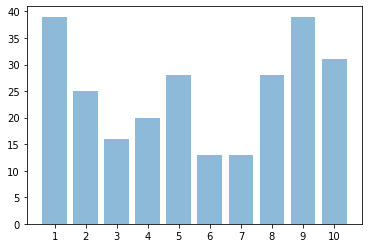

[39, 25, 16, 20, 28, 13, 13, 28, 39, 31]


In [40]:
wrongPredictions = [0,0,0,0,0,0,0,0,0,0]

for i,row in data3.iterrows():
    if row[int(row['Y'])] != np.amax(row[:10]):
        wrongPredictions[(int(row['Y']))] += 1
        #print(i)
        
objects = ('1','2','3','4','5','6','7','8','9','10')
y_pos = np.arange(len(objects))
performance = wrongPredictions

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.show()

print(wrongPredictions)

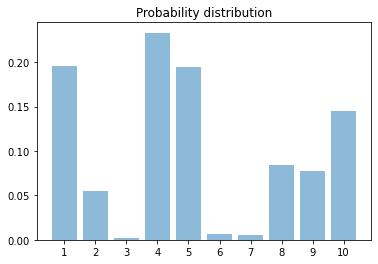

In [41]:
objects = ('1','2','3','4','5','6','7','8','9','10')
y_pos = np.arange(len(objects))
performance = values3[233]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.title('Probability distribution')

plt.show()